In [1]:
#!/usr/bin/python

# Import required modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

# Function Definitions

In [2]:
class ReadPDF(object):
    """ 
    Class for reading 2D gnuplot histogram files
    
    ---INPUT---
    filename: filename of the histogram file
    scale: scaling of histogram values; defaults to 1.0
    
    ---ATTRIBUTES---
    fname: filename
    data: histogram data
    dx: histogram bin size in x
    dy: histogram bin size in y
    """
    
    def __init__(self, filename, scale=1.0):
        self.fname = os.path.splitext(os.path.basename(filename))[0]
        self.data = []
        xPts = 0
        yPts = 0
        
        # Extract bin coordinates and histogram values
        with open(filename, 'r') as f:
            for line in f:
                if line == '\n':
                    xPts += 1
                elif line.strip().split()[0] == '#':
                    continue
                else:
                    if xPts == 0:
                        yPts += 1
                    self.data.append([float(k) for k in line.strip().split()])
                    
        # Reshape (and optionally scale) the matrix of histogram data
        self.data = np.reshape(self.data, (xPts, yPts, 3))
        self.data[:, :, 2] *= scale
        
        # Get bin size
        self.dx = abs(self.data[0, 0, 0] - self.data[xPts-1, 0, 0])/(xPts-1)
        self.dy = abs(self.data[0, 0, 1] - self.data[0, yPts-1, 1])/(yPts-1)
        
        # Reorganize the matrix of histogram data so that
        # histogram bin coordinates can be accessed by self.data[0] (x),
        # self.data[1] (y). Histogram values in self.data[2]
        self.data = np.moveaxis(self.data, -1, 0)
        
        # Close input file
        f.close()
        
    def __getitem__(self, idx):
        """
        Function allowing access to the histogram data
        
        ---INPUT---
        idx: index of matrix element
        
        ---OUTPUT---
        data[idx]: value of histogram at index idx
        """
        
        return self.data[idx]
    
def KullbackLieblerDivergence(P, Q):
    """
    Computation of KL divergence, DKL(P||Q)
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    
    ---OUTPUT---
    DKL: value of KL divergence
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element of histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        # and add small value to avoid divide by zeros
        # (KL divergence not defined at locations where probability is exactly zero)
        p = P[-1] + 1.0E-15
        q = Q[-1] + 1.0E-15
        
        # Compute individual values of the divergence sum
        dkl = p*np.log2(q/p)
        
        # Alternative to handling of divide by zeros
        #dkl[np.where(np.isnan(dkl))] = 0.0
        #dkl[np.where(np.isinf(dkl))] = 0.0
        
        # Sum the divergence values
        DKL = -np.sum(dkl)*dV
        
        return DKL

def JensenShannonDivergence(P, Q):
    """
    Computation of JS divergence, DJS(P||Q)
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    
    ---OUTPUT---
    DJS: value of JS divergence
    """
        
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Initialize matrix for mean of P and Q
        M = np.zeros(np.shape(P))
        
        # Assign histogram bin coordinates to match P
        M[0:-1] = P[0:-1]
        
        # Compute mean of probability distributions
        M[-1] = 0.5*(P[-1]+Q[-1])
        
        # Compute JS divergence
        DJS = 0.5*KullbackLieblerDivergence(P, M) + 0.5*KullbackLieblerDivergence(Q, M)
        
        return DJS
    
def BhattacharyyaDistance(P, Q):
    """
    Computation of Bhattacharyya distance and Bhattcharyya coefficient
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    
    ---OUTPUT---
    BC: Bhattacharyya coefficient
    DB: Bhattacharyya distance
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element of histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        p = P[-1]
        q = Q[-1]
        
        # Compute Bhattacharyya coefficient and distance
        BC = np.sum(np.sqrt(p*q))*dV
        DB = -np.log(BC)
        
        return BC, DB
    
def EarthMoverDistance(P, Q, k=1.0):
    """
    Computation of Earth Mover distance
    *** I'm not sure if this is correct, so it is currently unused ***
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    k: Distance exponent; defaults to 1.0
    
    ---OUTPUT---
    EM: Earth Mover distance
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element of histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        p = P[-1]
        q = Q[-1]
        
        # Compute Earth Mover Distance
        EM = (np.sum((p-q)**k)*dV)**(1.0/k)
        
        return EM
    
def BinOverlap(P, Q, cutoff=0.0):
    """
    Computation of 'Bin Overlap' and 'Density Overlap' metrics 
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    cutoff: Cutoff value for saying whether or not a bin contains probability from P and Q;
            defaults to 0.0
    
    ---OUTPUT---
    overlap: 'Density Overlap' metric
    overlapCt: 'Bin Overlap' metric
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element of histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        p = P[-1]
        q = Q[-1]
        
        # Find where the values of the p AND q histograms are greater than cutoff
        # to find the overlap region
        overlapIdxs = np.logical_and(p > cutoff, q > cutoff)
        
        # Sum histogram values at within the overlap region
        overlap = np.sum(p[overlapIdxs])*dV
        
        # Count the number of histogram bins in the overlap region
        overlapBins = np.count_nonzero(p[overlapIdxs])
        
        # Count the number of bins where histogram is greater than cutoff
        nonzeroBins = np.count_nonzero(p)
        
        # Compute proportion of bins in the overlap region
        overlapCt = np.true_divide(overlapBins, nonzeroBins)
        
        return overlap, overlapCt
    
def IntegralOverlap(P, Q):
    """
    Computation of the traditional integral overlap 
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    
    ---OUTPUT---
    overlap: integral overlap
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element for the histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        p = P[-1]
        q = Q[-1]
        
        # Discrete integral of histogram overlap
        overlap = np.sum(np.minimum(p, q))*dV
        
        return overlap
    
def VolElement(P):
    """
    Automatic computation of histogram bin size 
    
    ---INPUT---
    P: Probability distribution (i.e., histogram matrix)
    
    ---OUTPUT---
    dV: volume of histogram bin
    """
    
    # Dimensionality of the histogram
    nDim = len(np.shape(P))
    
    # 3D histogram
    if nDim == 4:
        
        # Spacing in x
        dx = np.abs(P[0, 0, 0, 0]-P[0, -1, 0, 0])/(np.shape(P)[-3]-1)
        
        # Spacing in y
        dy = np.abs(P[1, 0, 0, 0]-P[1, 0, -1, 0])/(np.shape(P)[-2]-1)
        
        # Spacing in z
        dz = np.abs(P[2, 0, 0, 0]-P[2, 0, 0, -1])/(np.shape(P)[-1]-1)
        
        # Compute volume
        dV = dx*dy*dz
        
    # 2D histogram
    elif nDim == 3:
        dx = np.abs(P[0, 0, 0]-P[0, -1, 0])/(np.shape(P)[-2]-1)
        dy = np.abs(P[1, 0, 0]-P[1, 0, -1])/(np.shape(P)[-1]-1)
        dV = dx*dy
        
    # 1D histogram
    elif nDim == 2:
        dV = np.abs(P[0, 0]-P[0, -1])/(np.shape(P)[-1]-1)
        
    # Higher dimensions not implemented
    else:
        sys.exit('No valid dimension with which to compute volume element')
        
    return dV

def ProbabilityofGuessingCorrectlyDB(P, Q, P_DB=0.5):
    """
    Probability of Guessing correctly the database to which a structure belongs with respect to a feature
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    P_DB: Probability of IZA database (P_DB = 0.5 is the assumption of maximum entropy,
          where IZA and DEEM databases are equally probable)
    
    ---OUTPUT---
    PGDB: Probability distribution of guessing the DB correctly as a function of the value of the feature
    """
    
    # Compute volume element for the histogram bins
    dV = VolElement(P)        
        
    # Compute the joint probabilities 
    P_JOINT_DB1_F = P[-1] * P_DB
    P_JOINT_DB2_F = Q[-1] * (1 - P_DB)
        
    # Compute the probability that the feature takes value PHI regardless the database
    PF = P_JOINT_DB1_F + P_JOINT_DB2_F + 1.0E-15
    #PF = P_JOINT_DB1_F + P_JOINT_DB2_F
    
    P_COND_DB_F = np.zeros(np.shape(PF))
            
    # Compute the probability of the structure belonging to DB1 given that the value of the feature is PHI
    P_COND_DB_F = P_JOINT_DB1_F / PF
    #idxs = np.where(PF > 0.0)
    #P_COND_DB_F[idxs] = P_JOINT_DB1_F[idxs] / PF[idxs]
        
    # Compute the probability of guessing correctly
    pgdb = np.abs(P_COND_DB_F - 0.5) * PF
        
    PGDB = 2.0 * np.sum(pgdb) * dV
        
    return PGDB

# PCA Plots

In [24]:
# Select random subset of DEEM 10k PCA environments
nEnv = 505461 # Number of Si environments in DEEM 10k dataset
nPlot = 50000 # Number of Si environments to plot
nBatch = 10 # Number of batches for DEEM data
randomIdxs = np.arange(0, nEnv)
np.random.shuffle(randomIdxs)
plotIdxs = randomIdxs[0:nPlot]

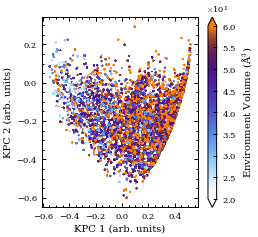

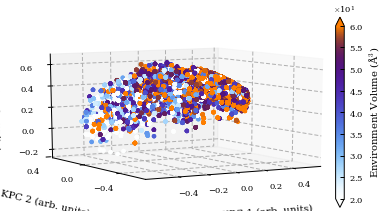

In [25]:
# Load DEEM 1k PCA (3.5 A SOAP cutoff) and structure volumes
pcaDEEM_1k_3A = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')
volumes_1k_3A = np.loadtxt('../Processed_Data/DEEM_1k/Volume/3.5/Gaussian/envProperties-0.dat')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM_1k_3A[:, 0], pcaDEEM_1k_3A[:, 1], c=volumes_1k_3A, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=20, vmax=60)

axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

# Custom formatting of colorbar ticks to use scientific notation
formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

# Build the colorbar
CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
txt = CB.ax.yaxis.get_offset_text()
CB.ax.minorticks_off()

# Set colorbar label size and text alignment
txt.set_va('bottom')
txt.set_ha('center')

# Colorbar label
CB.set_label(ur'Environment Volume (\u00c5$^3$)')

figPCA.savefig('../Results/DEEM_1k/kpca-DEEM_volumes_1k_3.5.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM_1k_3A[:, 0], pcaDEEM_1k_3A[:, 1], pcaDEEM_1k_3A[:, 2], 
                           c=volumes_1k_3A, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=20, vmax=60)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label(ur'Environment Volume (\u00c5$^3$)')

fig3D.savefig('../Results/DEEM_1k/kpca-DEEM_volumes_1k_3.5_3D.pdf', bbox_inches='tight')
plt.show()

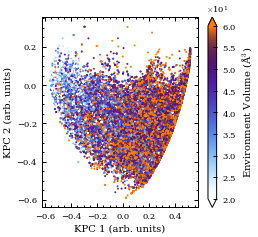

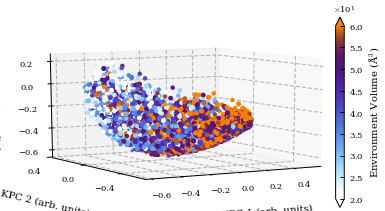

In [26]:
# Load DEEM 10k PCA (3.5 A SOAP cutoff) and structure volumes
n = 0
pcaDEEM_10k_3A = []
volumes_10k_3A = []
for i in range(0, nBatch):
    ipcaDEEM_10k_3A = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/3.5/Gaussian/envProperties-%d.dat' % i)
    subIdxs = np.intersect1d(plotIdxs[np.where(plotIdxs >= n)],
                            plotIdxs[np.where(plotIdxs < (n+len(ipcaDEEM_10k_3A)))]) - n
    n += len(ipcaDEEM_10k_3A)
    volumes_10k_3A.append(ivol[subIdxs])
    pcaDEEM_10k_3A.append(ipcaDEEM_10k_3A[subIdxs])
pcaDEEM_10k_3A = np.concatenate(pcaDEEM_10k_3A)
volumes_10k_3A = np.concatenate(volumes_10k_3A)
plotIdxs.sort()

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM_10k_3A[:, 0], pcaDEEM_10k_3A[:, 1], c=volumes_10k_3A, 
                           cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=20, vmax=60)

axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

# Custom formatting of colorbar ticks to use scientific notation
formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

# Build the colorbar
CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
txt = CB.ax.yaxis.get_offset_text()
CB.ax.minorticks_off()

# Set colorbar label size and text alignment
txt.set_va('bottom')
txt.set_ha('center')

# Colorbar label
CB.set_label(ur'Environment Volume (\u00c5$^3$)')

figPCA.savefig('../Results/DEEM_10k/kpca-DEEM_volumes_10k_3.5.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM_10k_3A[:, 0], pcaDEEM_10k_3A[:, 1], pcaDEEM_10k_3A[:, 2], c=volumes_10k_3A, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=20, vmax=60)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label(ur'Environment Volume (\u00c5$^3$)')

fig3D.savefig('../Results/DEEM_10k/kpca-DEEM_volumes_10k_3.5_3D.pdf', bbox_inches='tight')
plt.show()

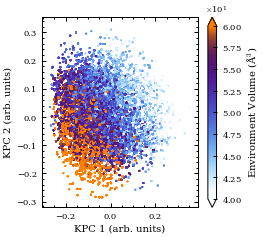

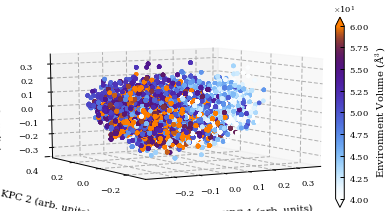

In [27]:
# Load DEEM 1k PCA (6.0 A SOAP cutoff) and structure volumes
pcaDEEM_1k_6A = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')
volumes_1k_6A = np.loadtxt('../Processed_Data/DEEM_1k/Volume/6.0/Gaussian/envProperties-0.dat')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM_1k_6A[:, 0], pcaDEEM_1k_6A[:, 1], c=volumes_1k_6A, 
                           cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=40, vmax=60)
axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB.set_label(ur'Environment Volume (\u00c5$^3$)')

figPCA.savefig('../Results/DEEM_1k/kpca-DEEM_volumes_1k_6.0.pdf', bbox_inches='tight')
plt.show()

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM_1k_6A[:, 0], pcaDEEM_1k_6A[:, 1], pcaDEEM_1k_6A[:, 2], c=volumes_1k_6A, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=40, vmax=60)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label(ur'Environment Volume (\u00c5$^3$)')

fig3D.savefig('../Results/DEEM_1k/kpca-DEEM_volumes_1k_6.0_3D.pdf', bbox_inches='tight')
plt.show()

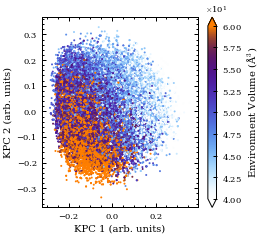

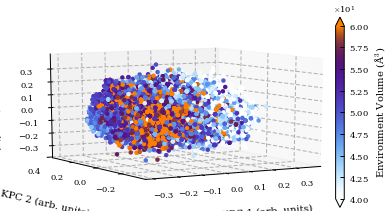

In [28]:
n = 0
pcaDEEM_10k_6A = []
volumes_10k_6A = []
for i in range(0, nBatch):
    ipcaDEEM_10k_6A = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/6.0/Gaussian/envProperties-%d.dat' % i)
    subIdxs = np.intersect1d(plotIdxs[np.where(plotIdxs >= n)],
                            plotIdxs[np.where(plotIdxs < (n+len(ipcaDEEM_10k_6A)))]) - n
    n += len(ipcaDEEM_10k_6A)
    pcaDEEM_10k_6A.append(ipcaDEEM_10k_6A[subIdxs])
    volumes_10k_6A.append(ivol[subIdxs])
pcaDEEM_10k_6A = np.concatenate(pcaDEEM_10k_6A)
volumes_10k_6A = np.concatenate(volumes_10k_6A)

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM_10k_6A[:, 0], pcaDEEM_10k_6A[:, 1], c=volumes_10k_6A, 
                           cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=40, vmax=60)
axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB.set_label(ur'Environment Volume (\u00c5$^3$)')

figPCA.savefig('../Results/DEEM_10k/kpca-DEEM_volumes_10k_6.0.pdf', bbox_inches='tight')
plt.show()

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM_10k_6A[:, 0], pcaDEEM_10k_6A[:, 1], pcaDEEM_10k_6A[:, 2], c=volumes_10k_6A, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=40, vmax=60)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label(ur'Environment Volume (\u00c5$^3$)')

fig3D.savefig('../Results/DEEM_10k/kpca-DEEM_volumes_10k_6.0_3D.pdf', bbox_inches='tight')
plt.show()

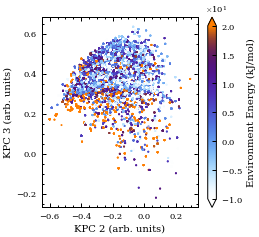

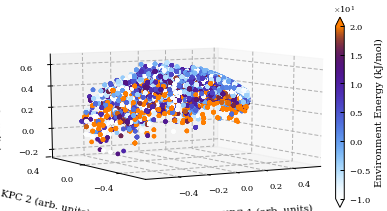

In [29]:
# Load DEEM PCA (3.5 A SOAP cutoff) and structure energies_1k_3A
pcaDEEM_1k_3A = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')
energies_1k_3A = np.loadtxt('../Processed_Data/DEEM_1k/Energy/3.5/Gaussian/envProperties-0.dat')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM_1k_3A[:, 1], pcaDEEM_1k_3A[:, 2], c=energies_1k_3A, 
                           cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=-10, vmax=20)

axsScat.set_xlabel('KPC 2 (arb. units)')
axsScat.set_ylabel('KPC 3 (arb. units)')

# Custom formatting of colorbar ticks to use scientific notation
formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

# Build the colorbar
CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()

# Set colorbar label size and text alignment
txt.set_va('bottom')
txt.set_ha('center')

# Colorbar label
CB.set_label('Environment Energy (kJ/mol)')

figPCA.savefig('../Results/DEEM_1k/kpca-DEEM_energies_1k_3.5.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM_1k_3A[:, 0], pcaDEEM_1k_3A[:, 1], pcaDEEM_1k_3A[:, 2], c=energies_1k_3A, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=-10, vmax=20)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label('Environment Energy (kJ/mol)')

fig3D.savefig('../Results/DEEM_1k/kpca-DEEM_energies_1k_3.5_3D.pdf', bbox_inches='tight')
plt.show()

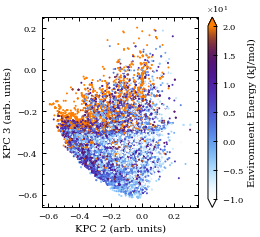

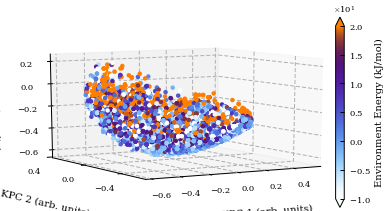

In [30]:
# Load DEEM PCA (3.5 A SOAP cutoff) and structure energies_10k_3A
n = 0
pcaDEEM_10k_3A = []
energies_10k_3A = []
for i in range(0, nBatch):
    ipcaDEEM_10k_3A = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/3.5/Gaussian/envProperties-%d.dat' % i)
    subIdxs = np.intersect1d(plotIdxs[np.where(plotIdxs >= n)],
                            plotIdxs[np.where(plotIdxs < (n+len(ipcaDEEM_10k_3A)))]) - n
    n += len(ipcaDEEM_10k_3A)
    pcaDEEM_10k_3A.append(ipcaDEEM_10k_3A[subIdxs])
    energies_10k_3A.append(ienergy[subIdxs])
pcaDEEM_10k_3A = np.concatenate(pcaDEEM_10k_3A)
energies_10k_3A = np.concatenate(energies_10k_3A)

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM_10k_3A[:, 1], pcaDEEM_10k_3A[:, 2], c=energies_10k_3A, 
                           cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=-10, vmax=20)

axsScat.set_xlabel('KPC 2 (arb. units)')
axsScat.set_ylabel('KPC 3 (arb. units)')

# Custom formatting of colorbar ticks to use scientific notation
formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

# Build the colorbar
CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()

# Set colorbar label size and text alignment
txt.set_va('bottom')
txt.set_ha('center')

# Colorbar label
CB.set_label('Environment Energy (kJ/mol)')

figPCA.savefig('../Results/DEEM_10k/kpca-DEEM_energies_10k_3.5.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM_10k_3A[:, 0], pcaDEEM_10k_3A[:, 1], pcaDEEM_10k_3A[:, 2], 
                           c=energies_10k_3A, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=-10, vmax=20)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label('Environment Energy (kJ/mol)')

fig3D.savefig('../Results/DEEM_10k/kpca-DEEM_energies_10k_3.5_3D.pdf', bbox_inches='tight')
plt.show()

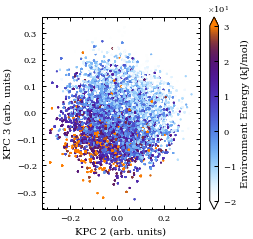

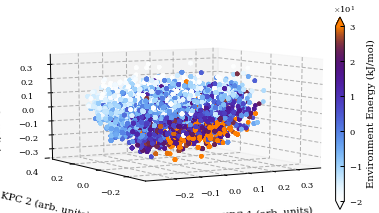

In [31]:
# Load DEEM PCA (6.0 A SOAP cutoff) and structure energies_1k_6A
pcaDEEM_1k_6A = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')
energies_1k_6A = np.loadtxt('../Processed_Data/DEEM_1k/Energy/6.0/Gaussian/envProperties-0.dat')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.54, 3.54))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM_1k_6A[:, 1], pcaDEEM_1k_6A[:, 2], c=energies_1k_6A, 
                           cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=-20, vmax=30)

axsScat.set_xlabel('KPC 2 (arb. units)')
axsScat.set_ylabel('KPC 3 (arb. units)')

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB.set_label('Environment Energy (kJ/mol)')

figPCA.savefig('../Results/DEEM_1k/kpca-DEEM_energies_1k_6.0.pdf', bbox_inches='tight')
plt.show()

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.54))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM_1k_6A[:, 0], pcaDEEM_1k_6A[:, 1], pcaDEEM_1k_6A[:, 2], c=energies_1k_6A, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=-20, vmax=30)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label('Environment Energy (kJ/mol)')

fig3D.savefig('../Results/DEEM_1k/kpca-DEEM_energies_1k_6.0_3D.pdf', bbox_inches='tight')
plt.show()

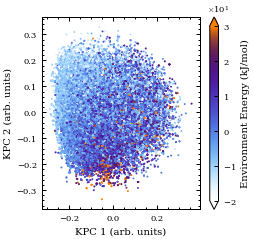

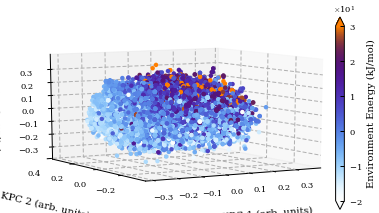

In [32]:
# Load DEEM PCA (6.0 A SOAP cutoff) and structure energies_10k_6A
n = 0
pcaDEEM_10k_6A = []
energies_10k_6A = []
for i in range(0, nBatch):
    ipcaDEEM_10k_6A = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/6.0/Gaussian/envProperties-%d.dat' % i)
    subIdxs = np.intersect1d(plotIdxs[np.where(plotIdxs >= n)],
                            plotIdxs[np.where(plotIdxs < (n+len(ipcaDEEM_10k_6A)))]) - n
    n += len(ipcaDEEM_10k_6A)
    pcaDEEM_10k_6A.append(ipcaDEEM_10k_6A[subIdxs])
    energies_10k_6A.append(ienergy[subIdxs])
pcaDEEM_10k_6A = np.concatenate(pcaDEEM_10k_6A)
energies_10k_6A = np.concatenate(energies_10k_6A)

### 2D PCA ###
figPCA = plt.figure(figsize=(3.54, 3.54))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM_10k_6A[:, 0], pcaDEEM_10k_6A[:, 1], c=energies_10k_6A, 
                           cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=-20, vmax=30)

axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB.set_label('Environment Energy (kJ/mol)')

figPCA.savefig('../Results/DEEM_10k/kpca-DEEM_energies_10k_6A_6.0.pdf', bbox_inches='tight')
plt.show()

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.54))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM_10k_6A[:, 0], pcaDEEM_10k_6A[:, 1], pcaDEEM_10k_6A[:, 2], c=energies_10k_6A, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=-20, vmax=30)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label('Environment Energy (kJ/mol)')

fig3D.savefig('../Results/DEEM_10k/kpca-DEEM_energies_10k_6A_6.0_3D.pdf', bbox_inches='tight')
plt.show()

# PDFs and Distance Metrics